In [ ]:
!pip install ctgan
!pip install sdv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load and Clean Data

In [ ]:
# ------------------ Data Paths ------------------ #
life_expecatncy_data = '/content/drive/My Drive/Life expectancy - Final Project/Data/Life Expectancy Data.csv'
smoking_data = '/content/drive/My Drive/Life expectancy - Final Project/Data/smoking_data.csv'

# ------------------ Load Datasets ------------------ #

le = pd.read_csv(life_expecatncy_data)
sm = pd.read_csv(smoking_data)




In [ ]:
# =============================================================================
# 1) preprocess Life Expectancy data
# =============================================================================
# Normalize column names
le.columns = (
    le.columns
      .str.strip()
      .str.replace(' ', '_')
      .str.replace('-', '_')
      .str.replace('%', 'pct')
)
# Keep only the needed columns
le = le[['Country', 'Life_expectancy', 'BMI', 'Alcohol', 'Schooling']].copy()
# Compute country‐level averages
le_avg = le.groupby('Country', as_index=False).mean(numeric_only=True)

# Fill missing values in each continuous column with its mean
for col in ['Life_expectancy','BMI','Alcohol','Schooling']:
    le_avg[col].fillna(le_avg[col].mean(), inplace=True)

<ipython-input-5-85f57c7fe0b2>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  le_avg[col].fillna(le_avg[col].mean(), inplace=True)


In [ ]:
# =============================================================================
# 2) preprocess Smoking data
# =============================================================================
sm.rename(columns={
    'Male Smokers (%)':   'Male_Smokers_pct',
    'Female Smokers (%)': 'Female_Smokers_pct',
}, inplace=True)

# now do your generic cleanup for the rest:
sm.columns = (
    sm.columns
      .str.strip()
      .str.replace(r'[()]',   '',    regex=True)  # remove ( and )
      .str.replace('%',      'pct')
      .str.replace(r'\s+|-', '_',   regex=True)
)
# Country-level male/female smoking prevalences
sm_avg = (
    sm.groupby('Country', as_index=False)
      .mean(numeric_only=True)[['Country', 'Male_Smokers_pct', 'Female_Smokers_pct']]
)


In [ ]:
from ctgan import CTGAN

# =============================================================================
# 3) Train CTGAN on the life expectancy distribution
# =============================================================================
ctgan = CTGAN(epochs=500, verbose=True)
train_df = le_avg[['Country', 'Life_expectancy', 'BMI', 'Alcohol', 'Schooling']]
ctgan.fit(train_df, discrete_columns=['Country'])


Gen. (0.00) | Discrim. (0.00):   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (-0.22) | Discrim. (-0.05): 100%|██████████| 500/500 [00:14<00:00, 35.22it/s]


In [ ]:
# -----------------------------------------------------------------------------
# 4) Generate synthetic samples
# -----------------------------------------------------------------------------
syn = ctgan.sample(1000000)
syn['Life_expectancy'] = syn['Life_expectancy'].clip(0, 120).round(1)
syn['BMI']              = syn['BMI'].clip(10, 60).round(1)
syn['Alcohol']          = syn['Alcohol'].clip(0, 20).round(2)
syn['Schooling']        = syn['Schooling'].clip(0, 20).round(1)

In [ ]:
# -----------------------------------------------------------------------------
# 5) Assign Sex at random (50/50)
# -----------------------------------------------------------------------------
syn['Sex'] = np.random.choice(['Male', 'Female'], size=len(syn), p=[0.5, 0.5])

In [ ]:
# -----------------------------------------------------------------------------
# 6) Merge smoking prevalences & sample 0/1 flag
# -----------------------------------------------------------------------------
#Ensure every country in le_avg appears in sm_avg:
all_countries = set(le_avg['Country'])
have_countries = set(sm_avg['Country'])
missing = sorted(all_countries - have_countries)

# compute global means from the existing sm_avg
male_global   = sm_avg['Male_Smokers_pct'].mean()
female_global = sm_avg['Female_Smokers_pct'].mean()

# build a small DataFrame for missing countries
fill_rows = pd.DataFrame({
    'Country':             missing,
    'Male_Smokers_pct':    male_global,
    'Female_Smokers_pct':  female_global
})
# concatenate and reset index
sm_complete = pd.concat([sm_avg, fill_rows], ignore_index=True)

syn = syn.merge(sm_complete, on='Country', how='left')

def sample_smoking(row):
    p = (row['Male_Smokers_pct']/100) if row['Sex']=='Male' \
        else (row['Female_Smokers_pct']/100)
    return np.random.binomial(1, p)

syn['Smoking'] = syn.apply(sample_smoking, axis=1)

# --- now drop the prevalence cols, keep only the binary flag: ---
syn = syn.drop(columns=['Male_Smokers_pct','Female_Smokers_pct'])

# --- final DataFrame with only the 0/1 Smoking column (plus your other features): ---
final = syn[['Country','Sex','Life_expectancy','BMI','Alcohol','Schooling','Smoking']]


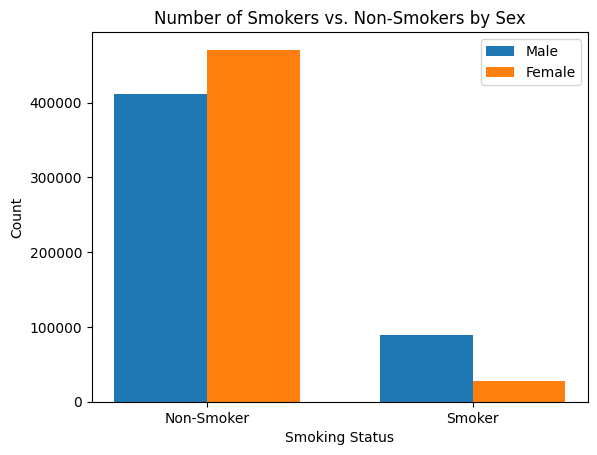

In [ ]:

# 1) Compute counts by Sex and Smoking status
counts = final.groupby(['Sex', 'Smoking']).size().unstack(fill_value=0)

# 2) Prepare bar chart parameters
labels = ['Non-Smoker', 'Smoker']
x = np.arange(len(labels))     # [0, 1]
width = 0.35                   # width of each bar

# 3) Create plot
fig, ax = plt.subplots()
ax.bar(x - width/2, counts.loc['Male'],   width, label='Male')
ax.bar(x + width/2, counts.loc['Female'], width, label='Female')

# 4) Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Smoking Status')
ax.set_ylabel('Count')
ax.set_title('Number of Smokers vs. Non-Smokers by Sex')
ax.legend()

# 5) Display
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# 7) Apply penalties to LifeExpectancy based on risk factors
# -----------------------------------------------------------------------------
adjusted_samples = final.copy()
for idx, person in adjusted_samples.iterrows():
    # Start with the original life expectancy
    le = person['Life_expectancy']
    # Smoking penalty
    if 'Smoking' in person.index and person['Smoking'] == 1:
        le -= 10  # smokers lose ~10 years [oai_citation_attribution:11‡archive.cdc.gov](https://archive.cdc.gov/www_cdc_gov/tobacco/data_statistics/fact_sheets/health_effects/tobacco_related_mortality/index.htm#:~:text=Cigarette%20smoking%20causes%20premature%20death%3A)
    # Alcohol penalty
    if 'Alcohol' in person.index and person['Alcohol'] >= 1:
      if person['Alcohol'] < 10:
        le -= 2   # low alcohol consumption lose ~2 years
      else:
        le -= 5   # heavy drinkers lose ~5 years [oai_citation_attribution:12‡livescience.com](https://www.livescience.com/62295-alcohol-guidelines-lower-limits.html#:~:text=Drinking%20more%20than%20100%20grams,year%20reduction%20in%20life%20expectancy)
    # Exercise penalty
    #if 'Exercise' in person.index and person['Exercise'] == 0:
    #    le -= 2   # physically inactive lose ~2 years [oai_citation_attribution:13‡pmc.ncbi.nlm.nih.gov](https://pmc.ncbi.nlm.nih.gov/articles/PMC3400064/#:~:text=Key%20messages)
    # Diet penalty
    #if 'Diet' in person.index and person['Diet'] == 0:
    #    le -= 5   # unhealthy diet can cost years (up to ~10) [oai_citation_attribution:14‡journals.plos.org](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003889#:~:text=years%20would%20increase%20LE%20by,UI%201.3)
    # Obesity penalty
    if 'BMI' in person.index:
       # obesity (BMI>=30) reduces life ~3 years [oai_citation_attribution:15‡ox.ac.uk](https://www.ox.ac.uk/news/2009-03-18-moderate-obesity-takes-years-life-expectancy#:~:text=Moderate%20obesity%20takes%20years%20off,expectancy%20by%20about%203%20years)
        bmi = person['BMI']
        if   bmi >= 40:
            le -= 10   # Class III obesity: up to 10 years lost
        elif bmi >= 35:
            le -= 6    # Class II obesity: ~6 years lost (midpoint)
        elif bmi >= 30:
            le -= 3    # Class I (moderate) obesity: ~3 years lost
    # Low education penalty
    if 'Schooling' in person.index and person['Schooling'] < 8:
        le -= 5   # very low education (~no high school) loses years [oai_citation_attribution:16‡societyhealth.vcu.edu](https://societyhealth.vcu.edu/work/the-projects/education-it-matters-more-to-health-than-ever-before.html#:~:text=Education%3A%20It%20Matters%20More%20to,Read%20More)

    # Update the adjusted life expectancy (ensure it doesn't go below 0)
    adjusted_samples.at[idx, 'Life_expectancy'] = max(le, 0)

# Round the adjusted life expectancy to nearest tenth
adjusted_samples['Life_expectancy'] = adjusted_samples['Life_expectancy'].round(1)

final_syn = adjusted_samples.copy()


In [ ]:
final_syn.to_csv("synthetic_life_expectancy_data.csv", index=False)

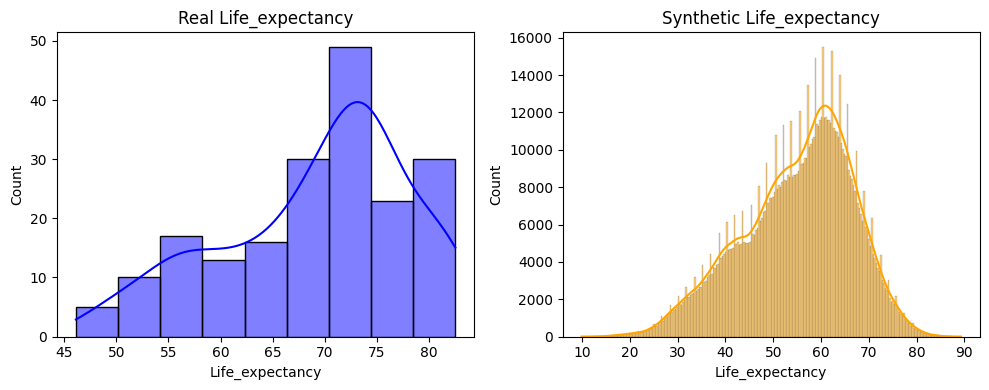

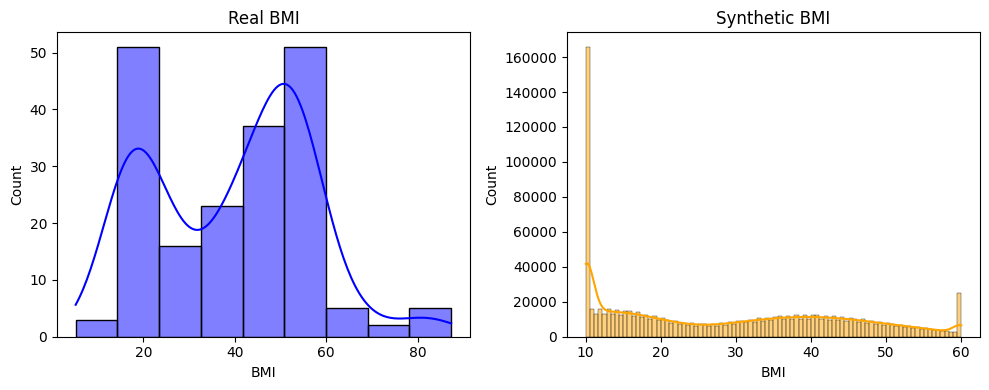

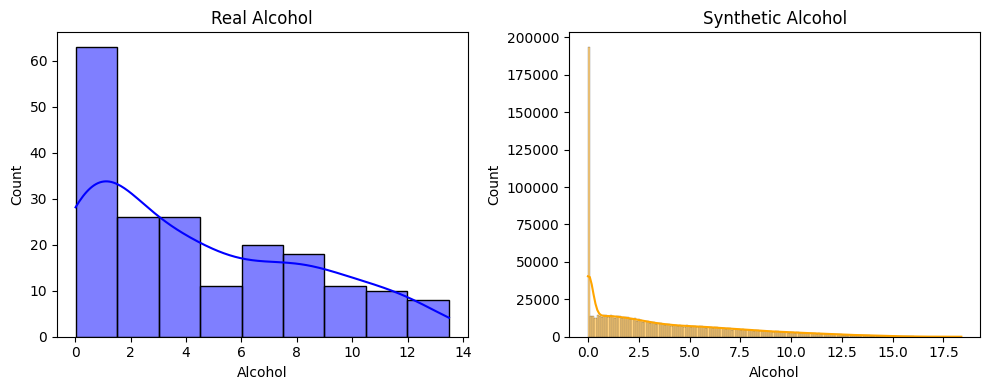

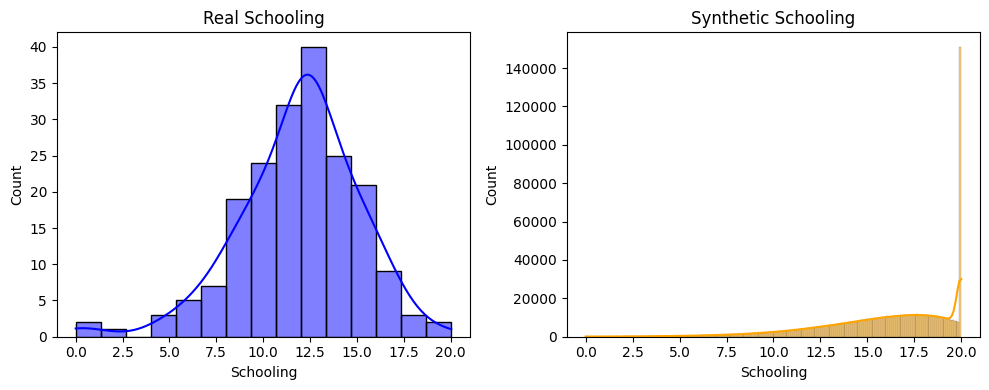

In [ ]:
for col in train_df.select_dtypes(include=['float64','int64']).columns:
    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    sns.histplot(train_df[col], kde=True, ax=ax[0], color='blue')
    ax[0].set_title(f"Real {col}")

    sns.histplot(final_syn[col], kde=True, ax=ax[1], color='orange')
    ax[1].set_title(f"Synthetic {col}")

    plt.tight_layout()
    plt.show()

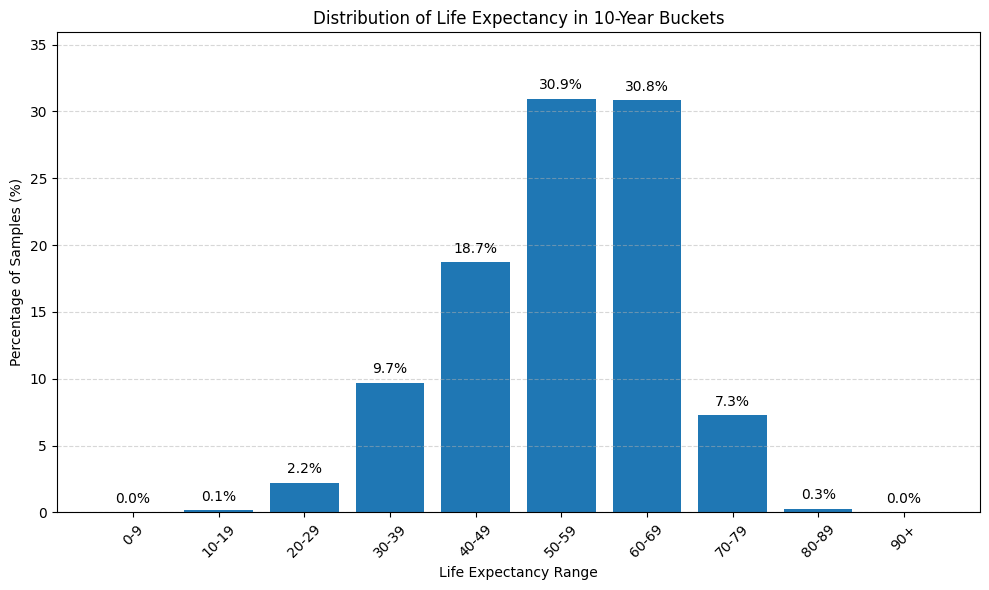

In [ ]:
life_expectancy = final_syn["Life_expectancy"]

bins = list(range(0, 101, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]
labels[-1] = "90+"

bucketed = pd.cut(life_expectancy, bins=[0,10,20,30,40,50,60,70,80,90,200], labels=labels, right=True, include_lowest=True)

percentages = bucketed.value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(percentages.index, percentages.values)
plt.xlabel("Life Expectancy Range")
plt.ylabel("Percentage of Samples (%)")
plt.title("Distribution of Life Expectancy in 10-Year Buckets")
plt.ylim(0, percentages.max() + 5)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:

real_corr = train_df.corr(numeric_only=True)
synth_corr = final_syn.corr(numeric_only=True)

print("Real Correlation:\n", real_corr)
print("\nSynthetic Correlation:\n", synth_corr)

Real Correlation:
                  Life_expectancy       BMI   Alcohol  Schooling
Life_expectancy         1.000000  0.633032  0.443958   0.697544
BMI                     0.633032  1.000000  0.291636   0.444144
Alcohol                 0.443958  0.291636  1.000000   0.559393
Schooling               0.697544  0.444144  0.559393   1.000000

Synthetic Correlation:
                  Life_expectancy       BMI   Alcohol  Schooling   Smoking
Life_expectancy         1.000000 -0.365196 -0.066188  -0.006951 -0.279123
BMI                    -0.365196  1.000000  0.028750  -0.037201 -0.000059
Alcohol                -0.066188  0.028750  1.000000   0.070248 -0.001150
Schooling              -0.006951 -0.037201  0.070248   1.000000  0.000536
Smoking                -0.279123 -0.000059 -0.001150   0.000536  1.000000


<ipython-input-17-95e323047604>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  alc_means = df.groupby('AlcRange')['Life_expectancy'].mean().reindex(alc_labels)
<ipython-input-17-95e323047604>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_means = df.groupby('BMICat')['Life_expectancy'].mean().reindex(bmi_labels)


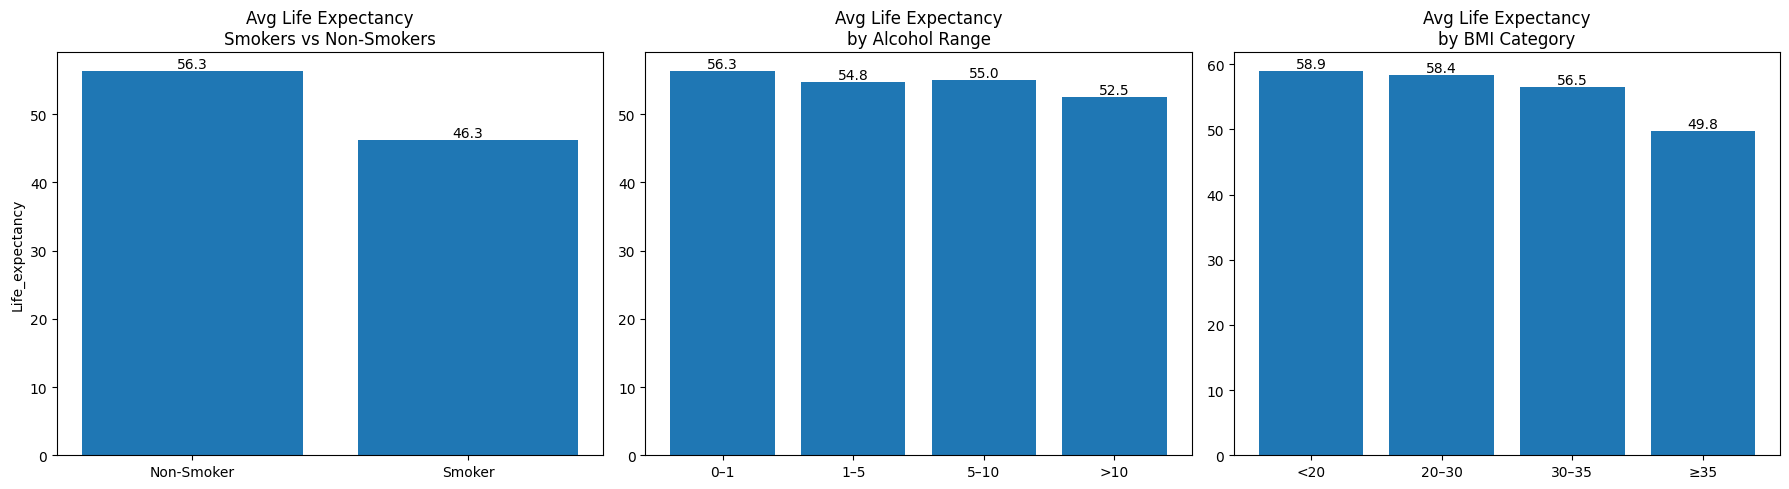

In [ ]:

df = final_syn.copy()

# 1) Smokers vs Non-Smokers
smoke_means = df.groupby('Smoking')['Life_expectancy'].mean().reindex([0,1])
smoke_labels = ['Non-Smoker', 'Smoker']

# 2) Alcohol consumption ranges
alc_bins   = [0, 1, 5, 10, np.inf]
alc_labels = ['0–1', '1–5', '5–10', '>10']
df['AlcRange'] = pd.cut(df['Alcohol'], bins=alc_bins, labels=alc_labels, right=False)
alc_means = df.groupby('AlcRange')['Life_expectancy'].mean().reindex(alc_labels)

# 3) BMI categories
bmi_bins   = [0, 20, 30, 35, np.inf]
bmi_labels = ['<20', '20–30', '30–35', '≥35']
df['BMICat'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)
bmi_means = df.groupby('BMICat')['Life_expectancy'].mean().reindex(bmi_labels)

# Plotting all three side by side
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# A) Smoking
x0 = np.arange(len(smoke_labels))
bars0 = axes[0].bar(x0, smoke_means.values)
axes[0].set_xticks(x0)
axes[0].set_xticklabels(smoke_labels)
axes[0].set_title('Avg Life Expectancy\nSmokers vs Non-Smokers')
axes[0].set_ylabel('Life_expectancy')
for rect in bars0:
    h = rect.get_height()
    axes[0].text(rect.get_x()+rect.get_width()/2, h, f'{h:.1f}', ha='center', va='bottom')

# B) Alcohol
x1 = np.arange(len(alc_labels))
bars1 = axes[1].bar(x1, alc_means.values)
axes[1].set_xticks(x1)
axes[1].set_xticklabels(alc_labels)
axes[1].set_title('Avg Life Expectancy\nby Alcohol Range')
for rect in bars1:
    h = rect.get_height()
    axes[1].text(rect.get_x()+rect.get_width()/2, h, f'{h:.1f}', ha='center', va='bottom')

# C) BMI
x2 = np.arange(len(bmi_labels))
bars2 = axes[2].bar(x2, bmi_means.values)
axes[2].set_xticks(x2)
axes[2].set_xticklabels(bmi_labels)
axes[2].set_title('Avg Life Expectancy\nby BMI Category')
for rect in bars2:
    h = rect.get_height()
    axes[2].text(rect.get_x()+rect.get_width()/2, h, f'{h:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()